
Conteo de Videos por Categoría:
               Categoría  Cantidad de Videos
0         Press de banca                  61
1  Elevaciones laterales                  37
2            Peso muerto                  32
3            Sentadillas                  29
4              Dominadas                  26
5          Press militar                  17
6                Plancha                   7

Duración Media por Categoría (en segundos):
               Categoría  Duración Media (s)
0              Dominadas            8.054119
1  Elevaciones laterales            8.319867
2            Peso muerto            5.862359
3                Plancha           47.807576
4         Press de banca            3.765388
5          Press militar           10.555951
6            Sentadillas           10.245224

Resolución Media por Categoría:
               Categoría  Ancho Medio (pixels)  Alto Medio (pixels)
0              Dominadas           1378.461538           775.384615
1  Elevaciones laterales         

C:\Users\Diego Castillo\AppData\Local\Temp\ipykernel_2116\3162236311.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=duration_mean, x='Categoría', y='Duración Media (s)', palette="Blues_d")


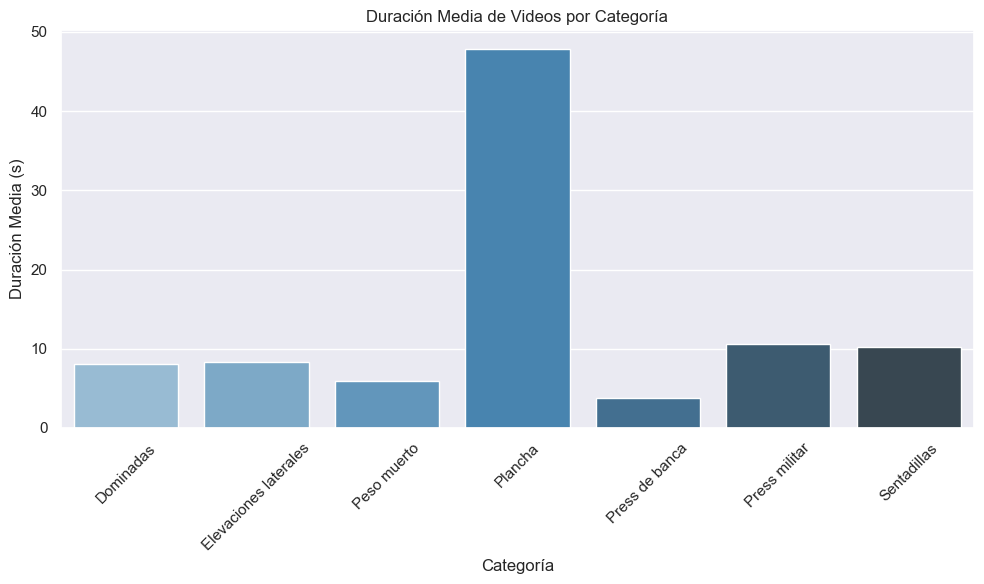

C:\Users\Diego Castillo\AppData\Local\Temp\ipykernel_2116\3162236311.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fps_mean, x='Categoría', y='FPS Medio', palette="Blues_d")


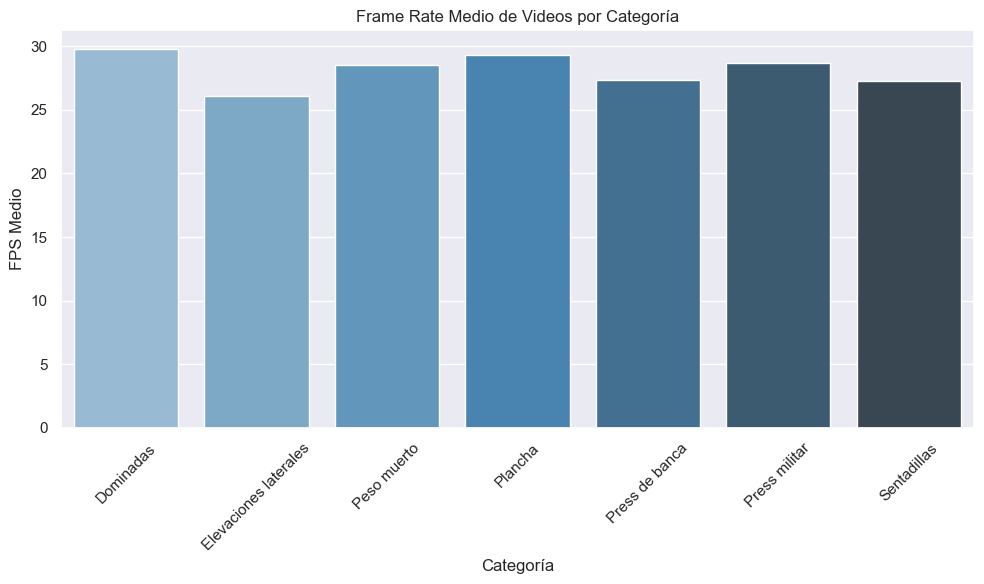

C:\Users\Diego Castillo\AppData\Local\Temp\ipykernel_2116\3162236311.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_mean, x='Categoría', y='Tamaño Medio (MB)', palette="Blues_d")


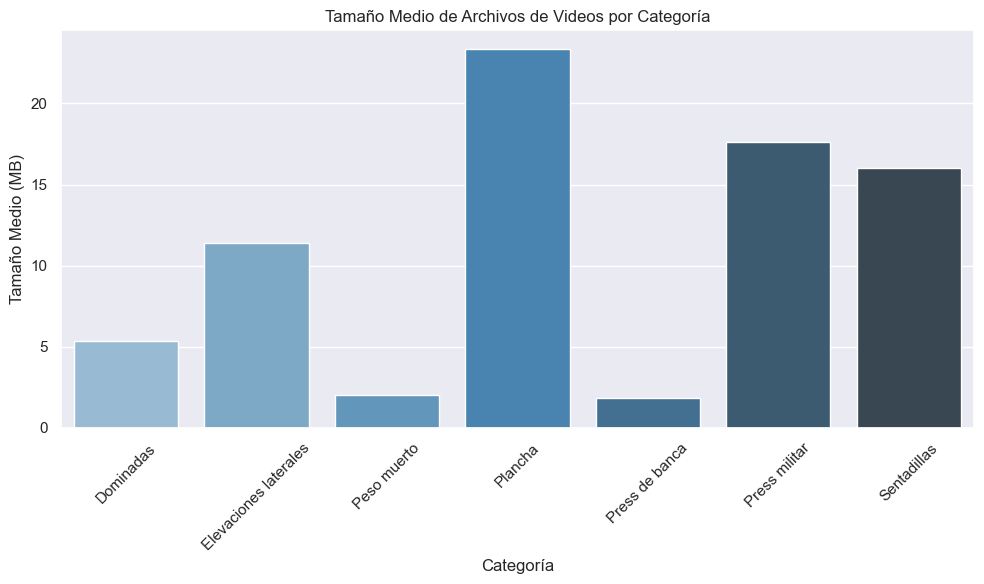

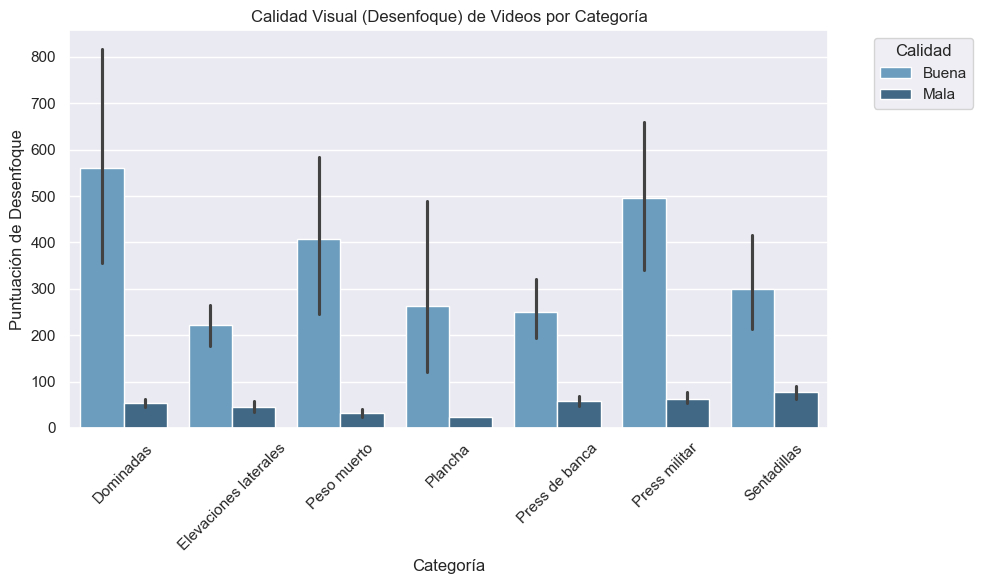

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuración para gráficos
sns.set(style="darkgrid", palette="Blues")

# Definir rutas
ruta_actual = os.getcwd()
ruta_raiz = os.path.dirname(ruta_actual)
data_dir = os.path.join(ruta_raiz, 'Data Set', 'videos 2')
categories = os.listdir(data_dir)

# Contenedores para resultados
video_info = []

# Función para procesar un video y extraer metadata
def analyze_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    # Obtener metadata
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps if fps > 0 else 0
    size = os.path.getsize(video_path)
    cap.release()
    
    return {
        'width': width,
        'height': height,
        'frame_count': frame_count,
        'fps': fps,
        'duration': duration,
        'size': size
    }

# Función para evaluar la calidad visual
def evaluate_visual_quality(video_path, num_samples=5):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    
    frame_indices = np.linspace(0, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1, num_samples, dtype=int)
    blur_scores = []
    
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            blur_score = cv2.Laplacian(gray_frame, cv2.CV_64F).var()
            blur_scores.append(blur_score)
    
    cap.release()
    return np.mean(blur_scores)

# Recorre las categorías y procesa los videos
for category in categories:
    category_path = os.path.join(data_dir, category)
    if not os.path.isdir(category_path):
        continue
    
    videos = os.listdir(category_path)
    
    for video in videos:
        video_path = os.path.join(category_path, video)
        metadata = analyze_video(video_path)
        if metadata:
            metadata.update({'category': category, 'video': video})
            quality_score = evaluate_visual_quality(video_path)
            metadata['blur_score'] = quality_score
            video_info.append(metadata)

# Convertir a DataFrame
video_info_df = pd.DataFrame(video_info)

# Definir umbral para mala calidad
umbral_mala_calidad = 100  # Ajusta según necesidad
video_info_df['Calidad'] = video_info_df['blur_score'].apply(lambda x: 'Mala' if x < umbral_mala_calidad else 'Buena')

# Guardar la información de videos en Excel
excel_file = 'video_analysis.xlsx'
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    video_info_df.to_excel(writer, sheet_name='Video_Info', index=False)

    # Tablas de análisis
    video_count = video_info_df['category'].value_counts().reset_index()
    video_count.columns = ['Categoría', 'Cantidad de Videos']
    video_count.to_excel(writer, sheet_name='Conteo_Videos', index=False)

    duration_mean = video_info_df.groupby('category')['duration'].mean().reset_index()
    duration_mean.columns = ['Categoría', 'Duración Media (s)']
    duration_mean.to_excel(writer, sheet_name='Duración_Media', index=False)

    resolution_mean = video_info_df.groupby('category')[['width', 'height']].mean().reset_index()
    resolution_mean.columns = ['Categoría', 'Ancho Medio (pixels)', 'Alto Medio (pixels)']
    resolution_mean.to_excel(writer, sheet_name='Resolución_Media', index=False)

    fps_mean = video_info_df.groupby('category')['fps'].mean().reset_index()
    fps_mean.columns = ['Categoría', 'FPS Medio']
    fps_mean.to_excel(writer, sheet_name='FPS_Medio', index=False)

    video_info_df['size_MB'] = video_info_df['size'] / (1024 * 1024)
    size_mean = video_info_df.groupby('category')['size_MB'].mean().reset_index()
    size_mean.columns = ['Categoría', 'Tamaño Medio (MB)']
    size_mean.to_excel(writer, sheet_name='Tamaño_Medio', index=False)

    visual_quality = video_info_df[['category', 'video', 'blur_score', 'Calidad']]
    visual_quality.columns = ['Categoría', 'Video', 'Puntuación de Desenfoque', 'Calidad']
    visual_quality.to_excel(writer, sheet_name='Calidad_Visual', index=False)

# Mostrar tablas
print("\nConteo de Videos por Categoría:")
print(video_count)

print("\nDuración Media por Categoría (en segundos):")
print(duration_mean)

print("\nResolución Media por Categoría:")
print(resolution_mean)

print("\nFrame Rate Medio por Categoría:")
print(fps_mean)

print("\nTamaño de Archivo Medio por Categoría (en MB):")
print(size_mean)

print("\nCalidad Visual (Desenfoque) para Todos los Videos:")
print(visual_quality)

# Visualización de Resultados

# Gráfico: Duración Media de Videos por Categoría
plt.figure(figsize=(10, 6))
sns.barplot(data=duration_mean, x='Categoría', y='Duración Media (s)', palette="Blues_d")
plt.title('Duración Media de Videos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Duración Media (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Duracion_Media_por_Categoria.png')
plt.show()

# Gráfico: Frame Rate Medio de Videos por Categoría
plt.figure(figsize=(10, 6))
sns.barplot(data=fps_mean, x='Categoría', y='FPS Medio', palette="Blues_d")
plt.title('Frame Rate Medio de Videos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('FPS Medio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Frame_Rate_Medio_por_Categoria.png')
plt.show()

# Gráfico: Tamaño de Archivos por Categoría
plt.figure(figsize=(10, 6))
sns.barplot(data=size_mean, x='Categoría', y='Tamaño Medio (MB)', palette="Blues_d")
plt.title('Tamaño Medio de Archivos de Videos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Tamaño Medio (MB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Tamano_Medio_por_Categoria.png')
plt.show()

# Gráfico: Calidad Visual (Desenfoque) de Todos los Videos
plt.figure(figsize=(10, 6))
sns.barplot(data=video_info_df, x='category', y='blur_score', hue='Calidad', palette="Blues_d")
plt.title('Calidad Visual (Desenfoque) de Videos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Puntuación de Desenfoque')
plt.xticks(rotation=45)
plt.legend(title='Calidad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Calidad_Visual_Videos.png')
plt.show()

